# Beam conditioning for LPA driven XFEL based on the VISA undulator
## 2019.12.13
### Ivan Gadjev
---

## Theory and Background

The energy spread of the electron beam used to drive a FEL must be less than the FEL parameter $\rho$. However, LPA e-beam sources have a very large energy spread inherent in the acceleration process in plasma-wakefields. 

---

## Simulation workflow

Run everything from this notebook. Can manipulate input files from notebook. If major changes are needed to an input file (especially for .ele and .lte files) it is recommended to edit the files separetely in a text editor. 

`elegant > manipulate beam > elegant transport > output to genesis > genesis > post-process genesis`

## Simulation cases

0. Optimization of the XFEL parameters 
1. No distfile genesis optimization
2. Distfile no energy spread
3. Increase energy spread until no gain
4. Beam condition on x-E
---

hello this is an equation on its own: $$\alpha = \beta + \exp(-i)$$

In [1]:
# reloads modules so that import does not have be run every time a module is changed
%load_ext autoreload
%autoreload 2

In [2]:
# needs sdds python module. see the elegant documentation.
import sdds

import datetime
import os
import sys
# !!! please change this path to match your configuration !!!
sys.path.append('D:/Dropbox/py_projects/elegenapi/src/features')
import elegenapi as ega

import numpy as np
import scipy.constants as pc
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as mcm

## def + calc

In [3]:
# prelim calculations

def gammabeta(gamma):
    """ compute the gamma*beta relativistic quantity from gamma = U/mc2"""
    gb = gamma * np.sqrt( 1 - 1/gamma**2 )
    return gb

def elegen(pathele0, fileele0, 
           genpath, sddsout, gendf,
           genin, genout,
           bc=False, bcmethod=0, aBC=1.0, gammaresonant=451, momoffMeV=0.0,
           chargegen=12.0e-9,
           verbose=False, plot=False):
    """ puts the process of running a custom distfile genesis sims in a function 
    
    pathele0 -  elegant init path
    fileele0 - elegant init filename. defines the initial particle distribution
    genpath - path to genesis folder
    sddsout - sdds output from particle manipulations
    gendf - name of DISTFILE created from sddsout
    genin - genesis input filename (must be inside genpath)
    genout - genesis output filename (will be created/overwritten inside genpath)
    
    bc=False - condition beam?
    aBC=1.0 - energy  = aBC * x^2
    gammaresonant=451 - resonant energy in optimized genesis simulations
    chargegen=12.0e-9 - charge equivalent to the current specified in optimized genesis input file (CURPEAK)
    
    verbose=False - print progress?
    """
    # === === === 
    # make initial SDDS
    # === === ===

    # initialize a 6D particle distribution from an empty lattice elegant run
    eleinit = ega.EleControl()
    eleinit.run_elegant(elepath=pathele0, inputfn=fileele0)
    if verbose:
        print('elegant was run and created the particle dist file: ' + fileele0 + '\nin the directory:\n' + pathele0)

    # === === === 
    # 6-d manipulation
    # === === ===

    # load the generated sdds and manipulate correlations
    beam = ega.ParticleDist()
    sddsfn = pathele0 + '/' + fileele0[:-4] + '_ebeam.sdds'
    beam.load_sdds(sddsfn)
    if verbose:
        print('loaded file: ' + sddsfn)

    if bc:
        # artificially make a parabolic correlation between x and energy
        gbele = gammabeta(gammaresonant)
        if bcmethod == 0:
            beam.xE_parabola(ascale=aBC, momres=gbele, momoffset=momoffMeV)
        elif bcmethod == 1:
            beam.xE_condition(ascale=aBC, momres=gbele, momoffset=momoffMeV)
          
    if plot:
        # quick plot
        c1 = beam.collookup['x']
        c2 = beam.collookup['p']
        xvec = 1e6*beam.ebeamnp[c1,0,:]
        yvec = beam.ebeamnp[c2,0,:]
        plt.scatter(xvec, yvec)
        plt.xlabel('xpos (um)')
        plt.ylabel('gamma')
        # plt.scatter(xvec,(yvec - 138.5)/138.5, s=44, alpha=0.5)
        # plt.axis([-1000, 5000, -0.02,0.03])

    # === === === 
    # make distfile
    # === === ===
    
    # go to genesis path or create it if it does not exist
    if os.path.exists(genpath):
        os.chdir(genpath)
    else:
        os.mkdir(genpath)
        os.chdir(genpath)

    # save SDDS

    beam.save_sdds((genpath+sddsout), genpscale=True)
    if verbose:
        print('saved sdds to:\n' + genpath + sddsout)

    # write to text based distfile
    beam.create_genesis_distfile(sddsout, gendf, charge=chargegen)
    if verbose:
        print('genesis DISTFILE saved to: ' + genpath + gendf)
        print('\n===== \n===== \n=====')

    # === === === 
    # run genesis
    # === === ===

    gc = ega.GenControl(0)
    # change the name of the distfile and output files
    chparams = {'distfile':"'"+gendf+"'",            
                'outputfile':"'"+genout+"'"}
    gc.param_set(genin, chparams)

    try:
        gc.run_genesis(genin)
        print('genesis run finished. input file was: ' + genin)
    except:
        print('FAILED to run genesis.')
        
        
        
def print_stats(genpar, zrecnum=0):
    zrec = genpar.data.zrec == zrecnum
    
    xmean = 1e6*genpar.data[zrec].xposition.values.mean()
    xstd =  1e6*genpar.data[zrec].xposition.values.std()
    ymean = 1e6*genpar.data[zrec].yposition.values.mean()
    ystd =  1e6*genpar.data[zrec].yposition.values.std()

    print('x mean = {:06.3f} um\nx std = {:06.3f} um'.format(*[xmean, xstd]))
    print('y mean = {:06.3f} um\ny std = {:06.3f} um'.format(*[ymean, ystd]))

    pxmean = 1e3*genpar.data[zrec].xmomentum.values.mean()
    pxstd =  1e3*genpar.data[zrec].xmomentum.values.std()
    pymean = 1e3*genpar.data[zrec].ymomentum.values.mean()
    pystd =  1e3*genpar.data[zrec].ymomentum.values.std()

    print('px mean = {:06.3f} mrad\npx std = {:06.3f} mrad'.format(*[pxmean, pxstd]))
    print('py mean = {:06.3f} mrad\npy std = {:06.3f} mrad'.format(*[pymean, pystd]))
    
    return [xmean, xstd, ymean, ystd, pxmean, pxstd, pymean, pystd]

In [97]:
# genesis uses the relativistic gamma to define e-beam energy
gammagen = 452
# elegant uses p_mev 
gbele = gammabeta(gammagen)
mc2MeV = 1e-6 * pc.m_e * pc.c**2 / pc.e
print('gamma = {:06.4f} \ngamma*beta = {:06.4f}'.format(*[gammagen, gbele] ) )
print('U = gmc2 = {:06.4f} MeV\np = gbmc = {:06.4f} MeV/c'.format(*[gammagen*mc2MeV, gbele*mc2MeV]))

# beam charge used in the conversion from SDDS to distfile. made to match gain from genesis sims without distfile. 
equivalentgenesischarge = (5000/240)*1.0e-9
curpeak = 5e3
print(('genesis distfile charge = {:06.3e} C' + 
      '\ngenesis CURPEAK = {:06.3e} A' + 
      '\n=== Please check that these numbers are actually fed to the inputiles')
      .format(*[equivalentgenesischarge, curpeak]))
rxbeam=49.0e-6
rybeam=46.0e-6
emitx=1.1e-6
emity=1.1e-06

emitnx=1.1e-6
emitny=1.1e-6

betax=rxbeam*rxbeam*gammagen/emitnx
print('betax = {}'.format(betax))
betay=rybeam*rybeam*gammagen/emitny
print('betay = {}'.format(betay))

print(np.sqrt(betax*emitnx/gammagen)*1e6)
print(np.sqrt(betay*emitny/gammagen)*1e6)

print(np.sqrt(emitnx/gammagen/betax)*1e6)
print(np.sqrt(emitny/gammagen/betay)*1e6)


gamma = 433.9200 
gamma*beta = 433.9188
U = gmc2 = 221.7327 MeV
p = gbmc = 221.7321 MeV/c
genesis distfile charge = 2.083e-08 C
genesis CURPEAK = 5.000e+03 A
=== Please check that these numbers are actually fed to the inputiles
betax = 0.947129018181818
betay = 0.8347042909090908
49.00000000000001
46.0
51.73529588826681
55.109336924458134


# Global definitions

In [5]:
# elegant init path and filename for .ele file that creates the initial distribution
pathele0 = r'D:/Dropbox/py_projects/elegenapi/elegant/particle_dist_generation/'
fileele0 = 'particle_dist_init_lpa.ele'
print('elegant path for initial particle distributions')
print(pathele0)

# path to the genesis folder where sims and output are created
genpath = r'D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/'
# genpath += '2019-12-13/'
genpath += '2020-03-23/'

if os.path.exists(genpath):
    os.chdir(genpath)
else:
    os.mkdir(genpath)
    os.chdir(genpath)
print('genesis path for in files and output data')    
print(genpath)

elegant path for initial particle distributions
D:/Dropbox/py_projects/elegenapi/elegant/particle_dist_generation/
genesis path for in files and output data
D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/2020-03-23/


# CHANGE INPUT PARAMETERS

In [6]:

print(genpath)

if os.path.exists(genpath):
    os.chdir(genpath)
else:
    os.mkdir(genpath)
    os.chdir(genpath)

D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/2020-03-23/


In [98]:
# run genesis
gc = ega.GenControl(0)
genin = 'lpaxfel.in'
genout = 'lpaxfel_DF0_00'
chparams = {'NWIG':600,
            'XLAMDS':80.0e-9,
            'RXBEAM':49.0e-6,
            'RYBEAM':46.0e-6,
            'PRAD0':1e3,
            'DGRID':7e-3,
            'NCAR':251,
            'CURPEAK':5e3,
            'zstop':-1,
            'ippart':10,
            'scan':'GAMMA0',
            'nscan':1,
            'svar':0.001,
            'distfile':'delete',
            'outputfile':"'"+genout+"'"}
gc.param_set(genin, chparams)


---
# no DISTFILE genesis
---

In [22]:
print(genpath)
# run genesis
gc = ega.GenControl(0)
genin = 'lpaxfel.in'
genout = 'lpaxfel_DF0_00'
chparams = {'zstop':-1,
            'ippart':10,
            'distfile':'delete',
            'outputfile':"'"+genout+"'"}
gc.param_set(genin, chparams)

try:
    gc.run_genesis(genin)
    print('genesis run with input file: ' + genin)
except:
    print('FAILED to run genesis.')

D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/2020-03-23/
Run `genesis`.
genesis run with input file: lpaxfel.in


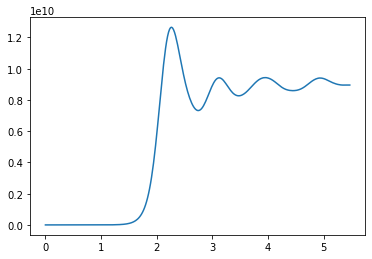

In [8]:
go = ega.GenOut()
genout = 'lpaxfel_DF0_00'
go.load(genout)
# print('The available data columns are:\n' + str(go.colnames))

plt.plot(go.data.z,go.data.power)

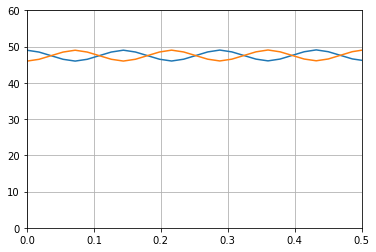

In [11]:
plt.plot(go.data.z,1e6* go.data.xrms)
plt.plot(go.data.z, 1e6*go.data.yrms)
plt.axis([0,.5, 0,60])
plt.grid()

In [6]:
gp = ega.GenPar()
gp.load(genout+'.par')
# print('The available data columns are:\n' + str(gp.colnames))

NameError: name 'genout' is not defined

In [9]:
transtats = print_stats(gp, 0)

x mean = 00.000 um
x std = 49.000 um
y mean = 00.000 um
y std = 46.000 um
px mean = 00.000 mrad
px std = 22.449 mrad
py mean = 00.000 mrad
py std = 23.913 mrad


---
# Small energy spread DISTFILE genesis
---
!!!

Must change energy spread inside the elegant file `fileele0` (see above) manually. Sorry, no fun. 

!!!

sddsprintout lpaxfel_dE0_BC0.sdds sdds_prinout.txt -columns=(p,t,x,y,xp,yp)
Run `genesis`.
genesis run finished. input file was: lpaxfel.in


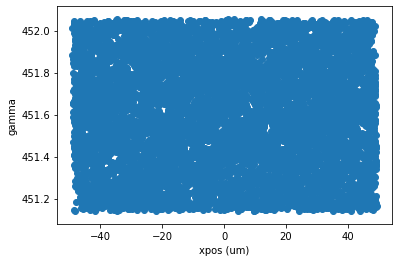

In [24]:
# print(genpath)

# filenames of the sdds output from particle manipulations and the distfile filename for input into genesis
sddsout = r'lpaxfel_dE0_BC0.sdds'
gendf = sddsout[:-5] + '.distfile'
# genesis input and output filenames
genin = 'lpaxfel.in'
genout = 'lpaxfel_DF1_00'

# make changes to genesis input file
gc = ega.GenControl(0)
chparams = {}
gc.param_set(genin, chparams)


aa = 142
mo = 0
bcm = 1
elegen(pathele0, fileele0, 
       genpath, sddsout, gendf,
       genin, genout,
       bc=False,
       bcmethod=bcm, aBC=aa, gammaresonant=gammagen, momoffMeV=mo,
       chargegen=equivalentgenesischarge,
       verbose=False,plot=True)


The available data columns are:
['z', 'aw', 'qfld', 'power', 'increment', 'powermid', 'realfieldmid', 'imagfieldmid', 'phasemid', 'w', 'wp', 'energy', 'bunching_1', 'realbunching_1', 'imagbunching_1', 'bunching_2', 'realbunching_2', 'imagbunching_2', 'bunching_3', 'realbunching_3', 'imagbunching_3', 'bunching_4', 'realbunching_4', 'imagbunching_4', 'bunching_5', 'realbunching_5', 'imagbunching_5', 'bunching_6', 'realbunching_6', 'imagbunching_6', 'bunching_7', 'realbunching_7', 'imagbunching_7', 'xrms', 'yrms', 'xp', 'yp', 'error', 'e-spread', 'farfield', 'slice']


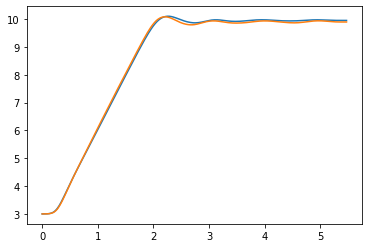

In [9]:
go00 = ega.GenOut()
genout = 'lpaxfel_DF1_00'
go00.load(genout)
print('The available data columns are:\n' + str(go00.colnames))

plt.plot(go.data.z,np.log10(go.data.power))
plt.plot(go00.data.z,np.log10(go00.data.power))

[0, 6.5, 0, 60]

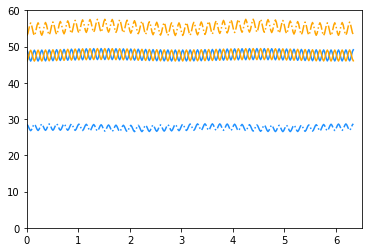

In [17]:
plt.plot(go.data.z,1e6* go.data.xrms,c='dodgerblue')
plt.plot(go.data.z,1e6* go.data.yrms,c='orange')
plt.plot(go00.data.z, 1e6*go00.data.xrms,'-.', c='dodgerblue')

plt.plot(go00.data.z, 1e6*go00.data.yrms,'-.',c='orange')
plt.axis([0,6.5,0 ,60])

In [47]:
gp00 = gen.GenPar()
gp00.load(genout+'.par')

Loaded .par filename = lpaxfel_DF1_00.par
The genesis .par file contains:
8 columns
36 z-records
8192 particles
Column names:
['energy', 'phase', 'xposition', 'yposition', 'xmomentum', 'ymomentum', 'zphase', 'theta', 'zrec']


[-300, 300, -300, 300]

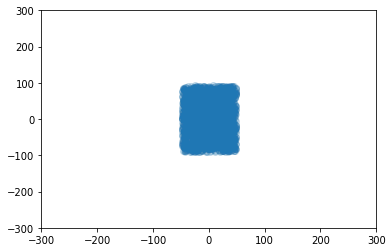

In [41]:
zrec = gp00.data.zrec == 0
plt.scatter(1e6*gp00.data[zrec].xposition.values, 1e6*gp00.data[zrec].yposition.values, alpha=0.05)
plt.axis([-300, 300, -300, 300])

In [42]:
transtats00 = print_stats(gp00, 0)

x mean = 00.394 um
x std = 28.516 um
y mean = 00.987 um
y std = 52.467 um
px mean = 00.147 mrad
px std = 12.906 mrad
py mean = -0.094 mrad
py std = 28.123 mrad


In [114]:
(452.3-450.9)/451.6/0.00075

4.133451431945775

---
# Large Energy Spread DISTFILE
---

sddsprintout lpaxfel_dE1_BC0.sdds sdds_prinout.txt -columns=(p,t,x,y,xp,yp)
Run `genesis`.
genesis run finished. input file was: lpaxfel.in


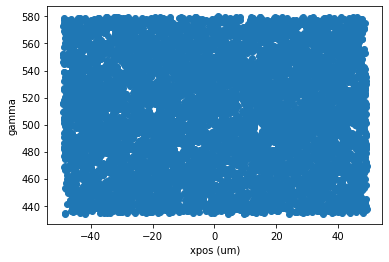

In [99]:
# print(genpath)

# filenames of the sdds output from particle manipulations and the distfile filename for input into genesis
sddsout = r'lpaxfel_dE1_BC0.sdds'
gendf = sddsout[:-5] + '.distfile'
# genesis input and output filenames
genin = 'lpaxfel.in'
genout = 'lpaxfel_DF1_10'

# make changes to genesis input file
gc = ega.GenControl(0)
chparams = {'XLAMDS':80.00e-9,
           'IPPART':10}
# chparams = {'XLAMDS':80e-9}
gc.param_set(genin, chparams)

# equivalentgenesischarge = 12.0e-9

aa = 0.0 # this actually positions all particles above the resonant gamma
mo = 0
bcm = 1
elegen(pathele0, fileele0, 
       genpath, sddsout, gendf,
       genin, genout,
       bc=True,
       bcmethod=bcm, aBC=aa, gammaresonant=gammagen, momoffMeV=mo,
       chargegen=equivalentgenesischarge,
       verbose=False,plot=True)


The available data columns are:
['z', 'aw', 'qfld', 'power', 'increment', 'powermid', 'realfieldmid', 'imagfieldmid', 'phasemid', 'w', 'wp', 'energy', 'bunching_1', 'realbunching_1', 'imagbunching_1', 'bunching_2', 'realbunching_2', 'imagbunching_2', 'bunching_3', 'realbunching_3', 'imagbunching_3', 'bunching_4', 'realbunching_4', 'imagbunching_4', 'bunching_5', 'realbunching_5', 'imagbunching_5', 'bunching_6', 'realbunching_6', 'imagbunching_6', 'bunching_7', 'realbunching_7', 'imagbunching_7', 'xrms', 'yrms', 'xp', 'yp', 'error', 'e-spread', 'farfield', 'slice']


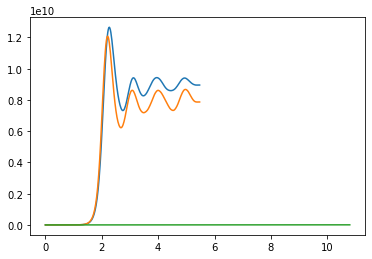

In [100]:
go10 = ega.GenOut()
genout = 'lpaxfel_DF1_10'
go10.load(genout)
print('The available data columns are:\n' + str(go10.colnames))

plt.plot(go.data.z,(go.data.power))
plt.plot(go00.data.z,(go00.data.power))
plt.plot(go10.data.z,(go10.data.power))

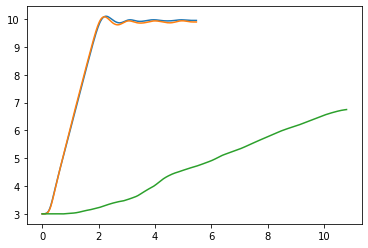

In [101]:
plt.plot(go.data.z,np.log10(go.data.power))
plt.plot(go00.data.z,np.log10(go00.data.power))
plt.plot(go10.data.z,np.log10(go10.data.power))

In [87]:
gp10 = ega.GenPar()

gp10.load('lpaxfel_DF1_10.par')

Loaded .par filename = lpaxfel_DF1_10.par
The genesis .par file contains:
8 columns
61 z-records
8192 particles
Column names:
['energy', 'phase', 'xposition', 'yposition', 'xmomentum', 'ymomentum', 'zphase', 'theta', 'zrec']


---
# Large Energy Spread DISTFILE + Beam Conditioning
---

sddsprintout lpaxfel_dE1_BC1.sdds sdds_prinout.txt -columns=(p,t,x,y,xp,yp)
Run `genesis`.
genesis run finished. input file was: lpaxfel.in


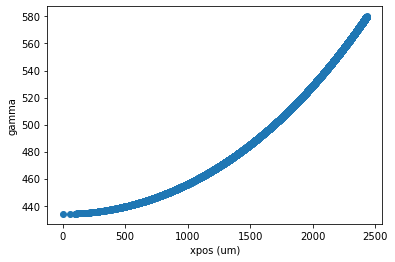

In [102]:
# print(genpath)

# filenames of the sdds output from particle manipulations and the distfile filename for input into genesis
sddsout = r'lpaxfel_dE1_BC1.sdds'
gendf = sddsout[:-5] + '.distfile'
# genesis input and output filenames
genin = 'lpaxfel.in'


# make changes to genesis input file
gc = ega.GenControl(0)
chparams = {'XLAMDS':80.00e-9,
           'IPPART':10}
# chparams = {'XLAMDS':80e-9}
gc.param_set(genin, chparams)

# equivalentgenesischarge = 12.0e-9
bcm = 1
if bcm == 1:
#     aa = 47.17e3
    aa = 66e3
    mo = 0

genout = 'lpaxfel_DF1_11_{:01d}'.format(*[bcm])

elegen(pathele0, fileele0, 
       genpath, sddsout, gendf,
       genin, genout,
       bc=True,
       bcmethod=bcm, aBC=aa, gammaresonant=gammagen, momoffMeV=mo,
       chargegen=equivalentgenesischarge,
       verbose=False,plot=True)


In [103]:
go111 = ega.GenOut()
genout = 'lpaxfel_DF1_11_1'
go111.load(genout)
print('The available data columns are:\n' + str(go111.colnames))

The available data columns are:
['z', 'aw', 'qfld', 'power', 'increment', 'powermid', 'realfieldmid', 'imagfieldmid', 'phasemid', 'w', 'wp', 'energy', 'bunching_1', 'realbunching_1', 'imagbunching_1', 'bunching_2', 'realbunching_2', 'imagbunching_2', 'bunching_3', 'realbunching_3', 'imagbunching_3', 'bunching_4', 'realbunching_4', 'imagbunching_4', 'bunching_5', 'realbunching_5', 'imagbunching_5', 'bunching_6', 'realbunching_6', 'imagbunching_6', 'bunching_7', 'realbunching_7', 'imagbunching_7', 'xrms', 'yrms', 'xp', 'yp', 'error', 'e-spread', 'farfield', 'slice']


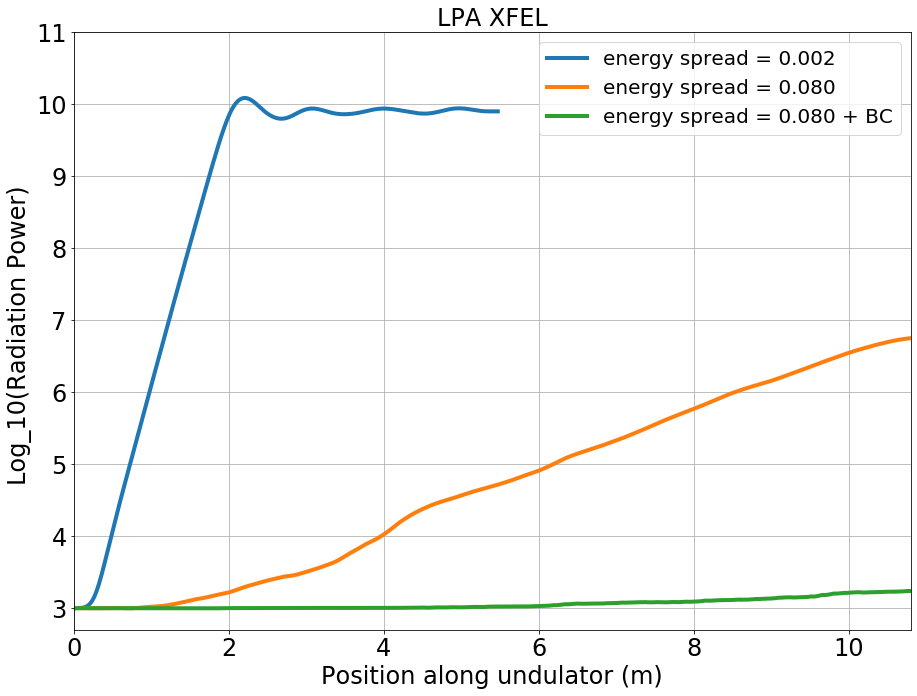

In [104]:
fig, ax = plt.subplots(figsize=(15,11))

ls = dict(linewidth=4,linestyle='-',alpha=1,ms=5)

try:
#     plt.plot(go.data.z,np.log10(go.data.power))
    ax.plot(go00.data.z,np.log10(go00.data.power), **ls)
    ax.plot(go10.data.z,np.log10(go10.data.power), **ls)
except NameError:
    print('skip plots of _,00,10')

xvec = go111.data.z
yvec = np.log10(go111.data.power)
ax.plot(xvec, yvec, **ls)

# xvec = go112.data.z
# yvec = np.log10(go112.data.power)
# plt.plot(xvec, yvec)

plt.grid()
fs = dict(fontsize=24)
plt.xlabel('Position along undulator (m)',**fs)
plt.ylabel('Log_10(Radiation Power) ', **fs)
plt.title('LPA XFEL', fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.axis([0, xvec.max(), 2.7, 11])

engspread = 0.08
aa = 62.7e3
mo = 0.0
plt.legend(['energy spread = 0.002', 
            'energy spread = {:04.3f}'.format(engspread), 
            'energy spread = {:04.3f} + BC'.format(*[engspread, aa, mo])],
           loc='best', 
           fontsize=20)


In [82]:
if True:
    figpath = r'd:/Dropbox/py_projects/elegenapi/reports/figures/20200324/'

    fig.savefig(figpath+r'log_Power_espread0.08.png',dpi=150,format='png',bbox_inches='tight')


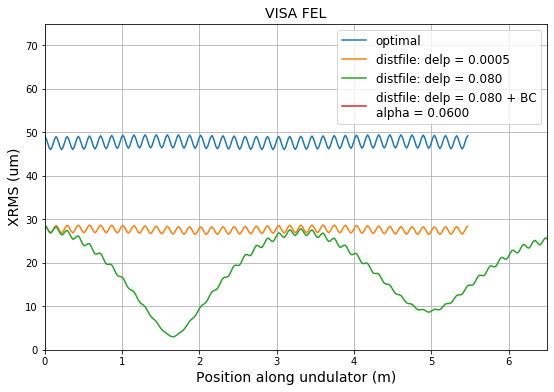

In [83]:
fig, ax = plt.subplots(figsize=(9,6))

try:
    plt.plot(go.data.z,1e6* go.data.xrms)
    plt.plot(go00.data.z, 1e6*go00.data.xrms)
    plt.plot(go10.data.z, 1e6*go10.data.xrms)
except NameError:
    pass
plt.plot(go111.data.z, 1e6*go111.data.xrms)
# plt.plot(go.data.z,1e6* go.data.yrms)
# plt.plot(go11.data.z, 1e6*go11.data.yrms)

plt.axis([0,6.5, 0,75])
plt.grid()
fs = dict(fontsize=14)
plt.xlabel('Position along undulator (m)',**fs)
plt.ylabel('XRMS (um)', **fs)
plt.title('VISA FEL', fontsize=14)
# engspread = 0.01
aa = 0.06
plt.legend(['optimal', 
            'distfile: delp = 0.0005', 
            'distfile: delp = {:04.3f}'.format(engspread), 
            'distfile: delp = {:04.3f} + BC\nalpha = {:05.4f}'.format(*[engspread, aa])],
           loc='best', 
           fontsize=12)

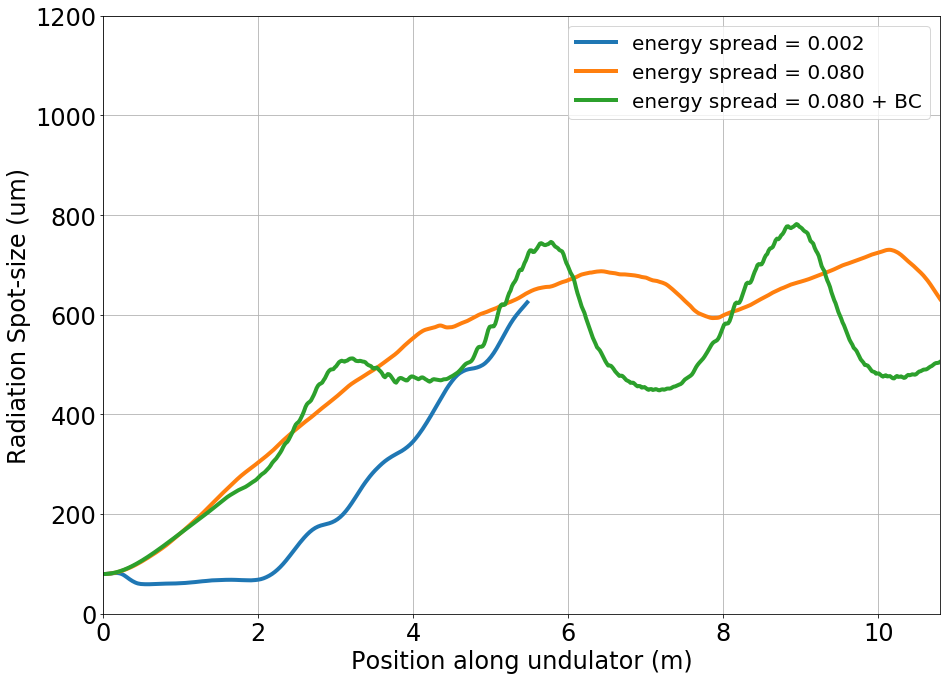

In [84]:
fig, ax = plt.subplots(figsize=(15,11))
ls = dict(linewidth=4,linestyle='-',alpha=1,ms=5)

yscl = 1e6

try:
#     plt.plot(go.data.z, yscl*(go.data.w))
    plt.plot(go00.data.z, yscl*(go00.data.w), **ls)
    plt.plot(go10.data.z, yscl*(go10.data.w), **ls)
except NameError:
    pass
plt.plot(go111.data.z, yscl*(go111.data.w), **ls)
# plt.plot(go112.data.z, yscl*(go112.data.w))

plt.axis([0,go111.data.z.max(), 0,1.2e3])
plt.grid()
fs = dict(fontsize=24)
plt.xlabel('Position along undulator (m)',**fs)
plt.ylabel('Radiation Spot-size (um)', **fs)
# plt.title('LPA XFEL', **fs)
plt.xticks(**fs)
plt.yticks(**fs)
plt.legend(['energy spread = 0.002', 
            'energy spread = {:04.3f}'.format(engspread), 
            'energy spread = {:04.3f} + BC'.format(*[engspread, aa, mo])],
           loc='best', 
           fontsize=20)




In [85]:
if True:
    figpath = r'd:/Dropbox/py_projects/elegenapi/reports/figures/20200324/'

    fig.savefig(figpath+r'radiation_spot_size_espread0.08.png',dpi=150,format='png',bbox_inches='tight')

In [86]:
gp111 = ega.GenPar()
# gp11.load(genout+'.par')
gp111.load('lpaxfel_DF1_11_1.par')

Loaded .par filename = lpaxfel_DF1_11_1.par
The genesis .par file contains:
8 columns
61 z-records
8192 particles
Column names:
['energy', 'phase', 'xposition', 'yposition', 'xmomentum', 'ymomentum', 'zphase', 'theta', 'zrec']


C:\Anaconda3\envs\accel_phys\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0.5, 1.0, 'LPA XFEL')

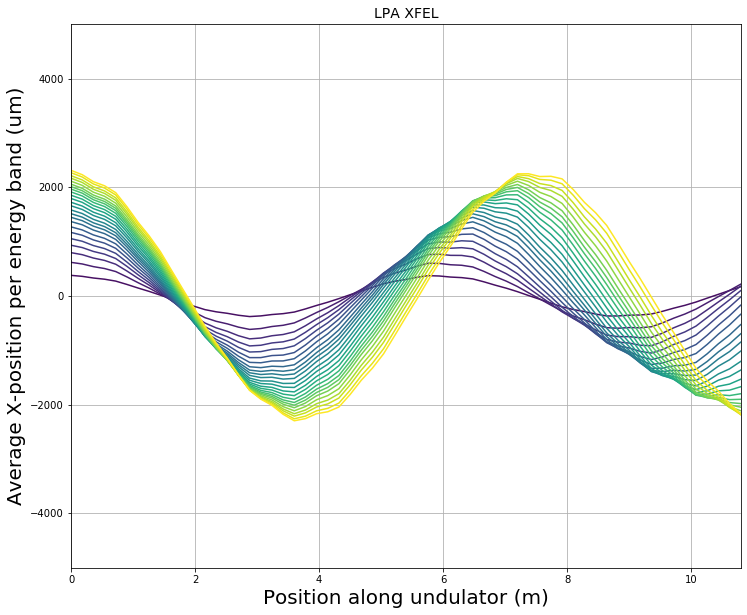

In [88]:
gptemp = gp111



xvec = gptemp.data.zrec.unique()* 0.018 * 10
ne = 25
qe = np.linspace(0.0,1,ne)

zrec = gptemp.data.zrec == 0
qe1 = gptemp.data[zrec].energy.quantile(0.1)
qe2 = gptemp.data[zrec].energy.quantile(0.6)


fig, ax = plt.subplots(figsize=(12,10))
for ii in range(ne-1):
    qe1 = gptemp.data[zrec].energy.quantile(qe[ii])
    qe2 = gptemp.data[zrec].energy.quantile(qe[ii+1])
    li0 = (gptemp.data[zrec].energy > qe1) & (gptemp.data[zrec].energy < qe2)
    yvec = (gptemp
            .data[li0]
            .groupby(['zrec'])
            .xposition
            .mean()
           )
    plt.plot(xvec, 1e6 * yvec, color=mcm.get_cmap('viridis')(qe[ii+1]))

plt.grid()
plt.axis([xvec.min(), xvec.max(), -5e3, 5e3])
fs = dict(fontsize=20)
plt.xlabel('Position along undulator (m)',**fs)
plt.ylabel('Average X-position per energy band (um)', **fs)
plt.title('LPA XFEL', fontsize=14)

In [89]:
if True:
    figpath = r'd:/Dropbox/py_projects/elegenapi/reports/figures/20200324/'

    fig.savefig(figpath+r'meanX_z_espread0.08.png',dpi=150,format='png',bbox_inches='tight')


C:\Anaconda3\envs\accel_phys\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


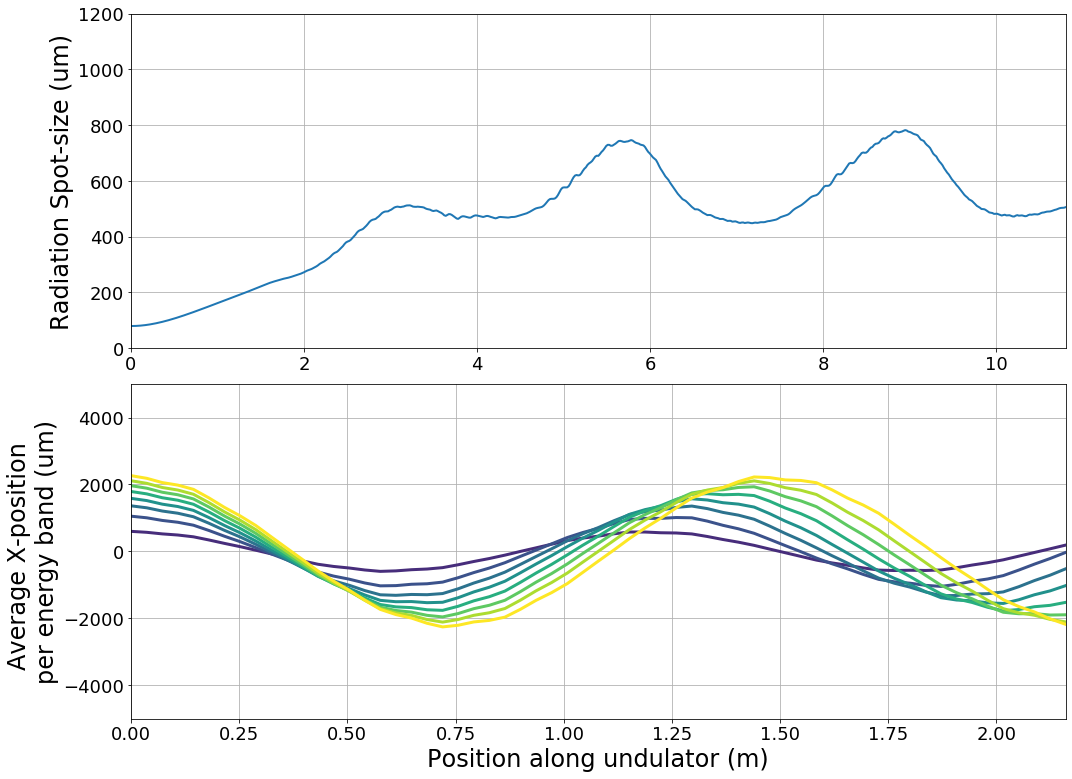

In [90]:
gptemp = gp111

fig, ax = plt.subplots(2,1,figsize=(15,11))

# 0 subplot

xvec = go111.data.z
yscl = 1e6
yvec = yscl*(go111.data.w)
# ax[0].plot(go111.data.z, yscl*(go111.data.w))
ax[0].plot(xvec, yvec, linewidth=2)
# plt.plot(go112.data.z, yscl*(go112.data.w))

ax[0].grid()
fs = dict(fontsize=24)
# ax[0].set_xlabel('Position along undulator (m)',**fs)
ax[0].axis([xvec.min(), xvec.max(), 0, 1.2e3])
ax[0].set_ylabel('Radiation Spot-size (um)', **fs)
ax[0].tick_params(labelsize=18)

# ax[0].legend(['energy spread = 0.0005', 
#             'energy spread = {:04.3f}'.format(engspread), 
#             'energy spread = {:04.3f} + BC\nalpha = {:05.2e}'.format(*[engspread, aa, mo])],
#            loc='best', 
#            fontsize=12)

# 1 subplot
xvec = gptemp.data.zrec.unique()* 0.018 * 2

ne = 9
qe = np.linspace(0.0,1,ne)

zrec = gptemp.data.zrec == 0
qe1 = gptemp.data[zrec].energy.quantile(0.1)
qe2 = gptemp.data[zrec].energy.quantile(0.6)

for ii in range(ne-1):
    qe1 = gptemp.data[zrec].energy.quantile(qe[ii])
    qe2 = gptemp.data[zrec].energy.quantile(qe[ii+1])
    li0 = (gptemp.data[zrec].energy > qe1) & (gptemp.data[zrec].energy < qe2)
    yvec = (gptemp
            .data[li0]
            .groupby(['zrec'])
            .xposition
            .mean()
           )
    ax[1].plot(xvec, 1e6 * yvec, color=mcm.get_cmap('viridis')(qe[ii+1]), linewidth=3)

ax[1].grid()
ax[1].axis([xvec.min(), xvec.max(), -5e3, 5e3])
ax[1].set_xlabel('Position along undulator (m)',**fs)
ax[1].set_ylabel('Average X-position \nper energy band (um)', **fs)
ax[1].tick_params(labelsize=18)
fig.tight_layout()

In [61]:
if True:
    figpath = r'd:/Dropbox/py_projects/elegenapi/reports/figures/20200324/'

    fig.savefig(figpath+r'combo_rad-size_meanX_z.png',dpi=150,format='png',bbox_inches='tight')


In [28]:
gp11.data.zrec.unique() * 0.018 * 10

array([0.  , 0.18, 0.36, 0.54, 0.72, 0.9 , 1.08, 1.26, 1.44, 1.62, 1.8 ,
       1.98, 2.16, 2.34, 2.52, 2.7 , 2.88, 3.06, 3.24, 3.42, 3.6 , 3.78,
       3.96, 4.14, 4.32, 4.5 , 4.68, 4.86, 5.04, 5.22, 5.4 , 5.58, 5.76,
       5.94, 6.12, 6.3 , 6.48, 6.66, 6.84, 7.02, 7.2 , 7.38, 7.56, 7.74,
       7.92, 8.1 , 8.28, 8.46, 8.64, 8.82, 9.  ])

C:\Anaconda3\envs\accel_phys\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


[0.0, 35.0, -1, 10]

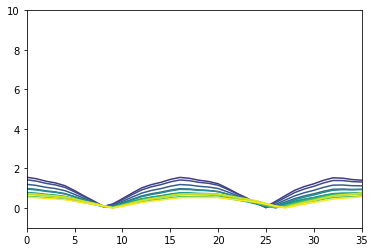

In [31]:
xvec = gp11.data.zrec.unique()
ne = 15
qe = np.linspace(0.1,1,ne)

zrec = gp11.data.zrec == 0
qe1 = gp11.data[zrec].energy.quantile(0.1)
qe2 = gp11.data[zrec].energy.quantile(0.6)



for ii in range(ne-1):
    qe1 = gp11.data[zrec].energy.quantile(qe[ii])
    qe2 = gp11.data[zrec].energy.quantile(qe[ii+1])
    li0 = (gp11.data[zrec].energy > qe1) & (gp11.data[zrec].energy < qe2)
    yvec = (gp11
            .data[li0]
            .groupby(['zrec'])
            .xposition
            .std()
           )
    plt.plot(xvec, 1e6 * yvec,color=mcm.get_cmap('viridis')(qe[ii+1]))
plt.axis([xvec.min(), xvec.max(), -1,10])

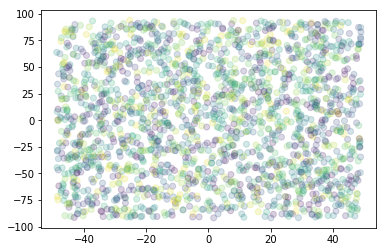

In [22]:
zrec = gp11.data.zrec == 0
plt.scatter(1e6*gp11.data[zrec].xposition.values, 1e6*gp11.data[zrec].yposition.values, c=gp11.data[zrec].energy.values, alpha=0.05)
# plt.axis([-300, 300, -300, 300])

## PARTICLE DISTRIBUTION PLOTS

In [31]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [23]:
def plotparticles(genpar, zz, 
                  xcol='xposition', ycol='yposition', 
                  xscale=1e6, yscale=1e6, 
                  xylims=[-1e3, 1e3, -200, 200],
                  yoffsetarr = 0
                 ):
    """ scatter plot of particles"""
    zrec = genpar.data.zrec == zz
    xvec = xscale * genpar.data[zrec][xcol].values
    if yoffsetarr == 0:
        yvec = yscale * genpar.data[zrec][ycol].values
    else:
        yvec = yscale * genpar.data[zrec][ycol].values - yoffsetarr[zrec]
    
    plt.scatter(xvec, yvec, alpha=0.05)
    
    plt.axis(xylims)
    plt.grid()
    plt.xlabel(xcol)
    plt.ylabel(ycol)

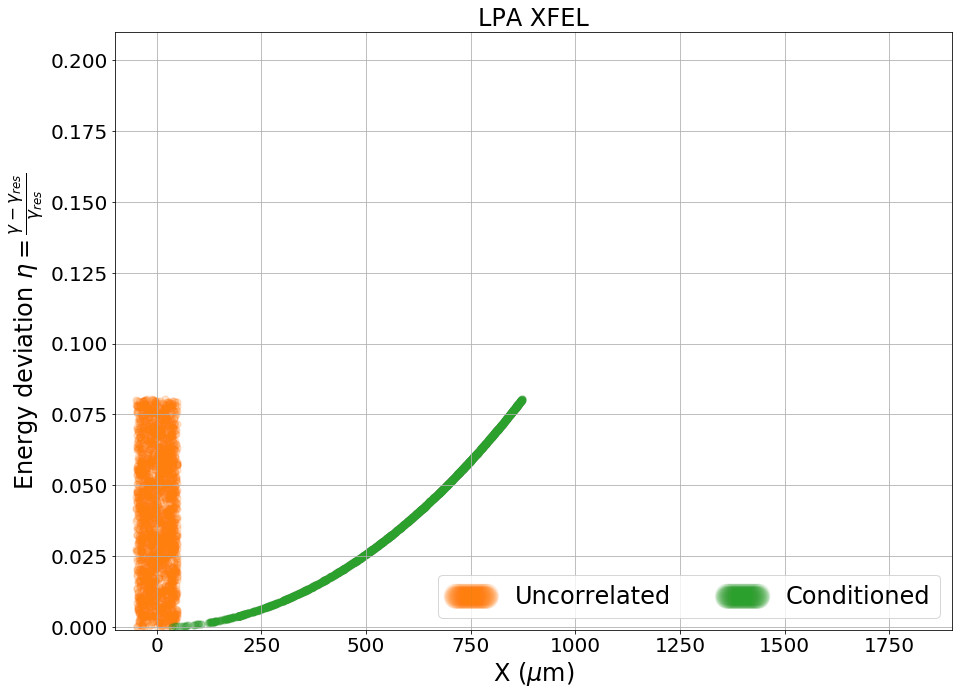

In [27]:
fig, ax = plt.subplots(figsize=(15,11))

gptemp = gp10
zrec = gptemp.data.zrec == 0
xscale=1e6
yscale=1
xvec = xscale * gptemp.data[zrec].xposition.values
yvec = yscale * gptemp.data[zrec].energy.values
yvec = (yvec - gbele) / gbele

scat0 = plt.scatter(xvec, yvec, c='tab:orange', s=50, alpha=0.05)

gptemp = gp111
xvec = xscale * gptemp.data[zrec].xposition.values
yvec = yscale * gptemp.data[zrec].energy.values
yvec = (yvec - gbele) / gbele
scat1 = ax.scatter(xvec, yvec, c='tab:green',s=50, alpha=0.05)

ax.legend((scat0, scat1),
          ('Uncorrelated', 'Conditioned'),
          scatterpoints=101,
          markerscale=3,
          loc='lower right',
          ncol=3,
          fontsize=24)

# plt.axis([-100, 1.3e3, 449, 490])
plt.axis([-100, 1.9e3, -0.001, 0.21])
plt.grid()
fs = dict(fontsize=24)
plt.xlabel('X ($\mu$m)',**fs)
plt.ylabel(r'Energy deviation $\eta = \frac{\gamma - \gamma_{res}}{ \gamma_{res}} $',**fs)
plt.title('LPA XFEL', **fs)
ax.tick_params(labelsize=20)


In [45]:
if True:
    figpath = r'd:/Dropbox/py_projects/elegenapi/reports/figures/lpaxfel_20191213/'

    fig.savefig(figpath+r'/particles_x-E.png',dpi=150,format='png',bbox_inches='tight')


In [59]:
gptemp = gp111
interactive_plot1 = interactive(plotparticles, 
                                genpar=fixed(gptemp), 
                                zz=widgets.IntSlider(min=0,max=(gptemp.nzrec-1),step=1,value=0),
                               xcol=fixed('xposition'), ycol=fixed('energy'),
                               xscale=fixed(1e6), yscale=fixed(1),
                               xylims=fixed([-1.5e3,1.5e3,450,500]))
output = interactive_plot1.children[-1]
output.layout.height = '350px'
interactive_plot1

interactive(children=(IntSlider(value=0, description='zz', max=300), IntSlider(value=0, description='yoffsetar…

In [111]:

(gptemp.data[gptemp.data.zrec == 0].energy.max() - gptemp.data[gptemp.data.zrec == 0].energy.min()) / gptemp.data[gptemp.data.zrec == 0].energy.mean()

0.020083366830444684

In [60]:
gptemp = gp11
interactive_plot1 = interactive(plotparticles, 
                                genpar=fixed(gptemp), 
                                zz=widgets.IntSlider(min=0,max=(gptemp.nzrec-1),step=1,value=0),
                               xcol='xposition', ycol='energy',
                               xscale=1e6, yscale=1,
                               xylims=fixed([-2e3,2e3,450,500]))
output = interactive_plot1.children[-1]
output.layout.height = '350px'
interactive_plot1

interactive(children=(IntSlider(value=0, description='zz', max=300), Text(value='xposition', description='xcol…

In [34]:
def plotparticles(genpar, zz, 
                  xcol='xposition', ycol='yposition', 
                  xscale=1e6, yscale=1e6, 
                  xylims=[-1e3, 1e3, -200, 200],
                  xoffsetarr = 0,
                  yoffsetarr = 0
                 ):
    """ scatter plot of particles"""
    zrec = genpar.data.zrec == zz
    if (xcol == 'phase'):
        if xoffsetarr != 0:
            xvec = xscale * np.mod(genpar.data[zrec][xcol].values - pc.pi - xoffsetarr[zz], 2*pc.pi ) - pc.pi
        else:
            xvec = xscale * np.mod(genpar.data[zrec][xcol].values - pc.pi, 2*pc.pi ) - pc.pi
    else:
        xvec = xscale * genpar.data[zrec][xcol].values
    
    if yoffsetarr == 0:
        yvec = yscale * genpar.data[zrec][ycol].values
    else:
        yvec = yscale * np.mod(genpar.data[zrec][ycol].values,2*pc.pi) - yoffsetarr[zz]
    
#     cvec = genpar.data[genpar.data.zrec == 0]['energy'].values
    xvec0 = xscale * np.mod(genpar.data[genpar.data.zrec == 0][xcol].values - pc.pi, 2*pc.pi ) - pc.pi
    cvec = xvec0
    plt.scatter(xvec, yvec, c=cvec, alpha=0.15, cmap='tab20c')
#     plt.scatter(xvec, yvec, alpha=0.05)
    
#     plt.axis(xylims)
    plt.grid()
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    
gptemp = gp111
interactive_plot1 = interactive(plotparticles, 
                                genpar=fixed(gptemp), 
                                zz=widgets.IntSlider(min=0,max=(gptemp.nzrec-1),step=1,value=0),
                               xcol='phase', ycol='energy',
                               xscale=1, yscale=1,
                               xylims=fixed([-1.1*pc.pi,1.1*pc.pi,135,148]),
                               xoffsetarr = fixed(0),
                               yoffsetarr = fixed(0))
output = interactive_plot1.children[-1]
output.layout.height = '350px'
interactive_plot1

interactive(children=(IntSlider(value=0, description='zz', max=60), Text(value='phase', description='xcol'), T…